In [0]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import shap

In [0]:
# Dataset that can be used to predict the chronic kidney diseas
df = pd.read_csv('kidney_disease.csv',sep=',', header=0)

In [5]:
df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35,7300,4.6,no,no,no,good,no,no,ckd


In [0]:
df=df.drop(['rbc'],axis=1)

In [0]:
df=df.drop(['sod'],axis=1)

In [0]:
df=df.drop(['wc'],axis=1)

In [0]:
df=df.drop(['pot'],axis=1)

In [10]:
df.isnull().sum()

id                  0
age                 9
bp                 12
sg                 47
al                 46
su                 49
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
hemo               52
pcv                70
rc                130
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64

In [0]:
df=df.dropna()

In [12]:
df.shape

(210, 22)

In [0]:
X=df.iloc[:,1:25]

In [0]:
y = (df['classification'] == "ckd")

## Create dummy variables from categorical variables


In [0]:
X_dum=X[['pc','pcc','ba','htn','dm','cad','appet','pe','ane']]

In [0]:
X_dum=pd.get_dummies(X_dum)

In [17]:
X_dum.head()


,pc_abnormal,pc_normal,pcc_notpresent,pcc_present,ba_notpresent,ba_present,htn_no,htn_yes,dm_no,dm_yes,cad_\tno,cad_no,cad_yes,appet_good,appet_poor,pe_no,pe_yes,ane_no,ane_yes
0,0,1,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0
3,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,0,1,0,1
4,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0
8,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1
9,1,0,0,1,1,0,0,1,0,1,0,1,0,0,1,1,0,0,1


In [0]:
result=pd.concat([X_dum,X[['age','bp','sg','al','su','bgr','bu','sc','hemo','pcv','rc']]],axis=1,sort=False)

## Fit a random forest classifier

Train a random forest classifier with 100 trees to estimate the probability of chronic kidney disease

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(result, y, random_state=42,stratify=y, test_size = 0.25)

clf = RandomForestClassifier(n_estimators = 100,max_depth=20)
clf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [20]:
y_pred=clf.predict(X_test)
y_pred

array([ True, False, False, False,  True,  True, False, False,  True,
        True,  True, False, False,  True, False, False, False,  True,
        True, False,  True, False,  True,  True, False, False,  True,
        True, False, False,  True, False,  True,  True, False, False,
        True,  True, False,  True, False, False, False, False, False,
       False,  True, False, False, False,  True,  True, False])

In [21]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


## Plot the Feature Importances


In [0]:
feature_importance = pd.Series(clf.feature_importances_,index=result.columns).sort_values(ascending=False)

Glyph 9 missing from current font.
Glyph 9 missing from current font.


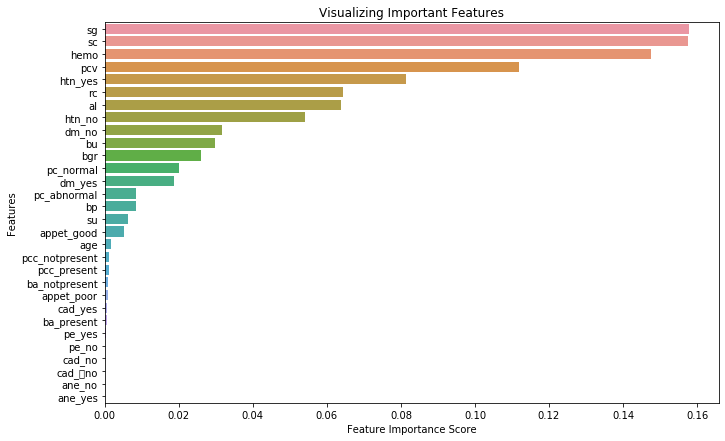

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Creating a bar plot
plt.figure(figsize=(11,7))
sns.barplot(x=feature_importance[0:35], y=feature_importance.index[0:35])

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

## Explain individual predictions using SHAP (SHapley Additive exPlanations)


Goal: explain the predicted output of a data point by getting the contribution of each feature to the prediction.

Use TreeSHAP estimation method.

In [25]:
explainer = shap.TreeExplainer(clf)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


### Select four subjects from the test set, with different predicted outputs and analyze their explanations.

In [26]:
y_test.loc[[0]]

0    True
Name: classification, dtype: bool

In [28]:
print(clf.predict_proba(X_test.loc[[0]]))
clf.predict(X_test.loc[[0]])

[[0.39 0.61]]


array([ True])

In [0]:
subject1 = X_test.loc[[0]]
shap_values1 = explainer.shap_values(subject1)

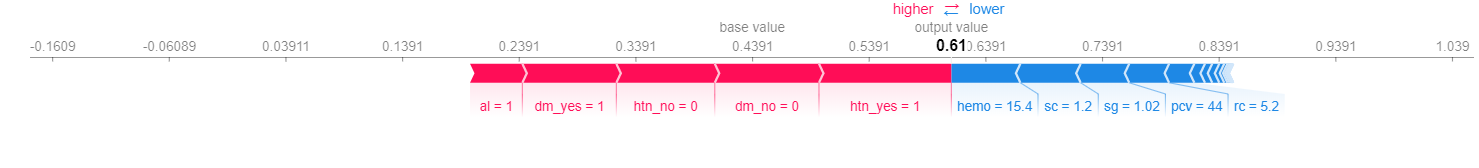

In [55]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values1[1], subject1)
# because github does not support the following plots, insert photos of them
from IPython.display import Image
Image("s1.PNG")

Each feature value can increase (red) or decrease (blue) the prediction. The base value of 0.4391 represents the average of all predicted probabilites in the dataset.

Consider the first subject, that suffers from chronic kidney disease. The predicted risk is 0.61, where feature values such as the presence of Diabetes Mellitus (dm_yes=1) and Hypertension (htn_yes=1) increase the risk of kidney disease, but they are balanced out by the decreasing effects of Hemoglobin (hemo = 15.4), or Serum Creatinine (sc=1.2).

In [33]:
print(y_test.loc[[271]])
print(clf.predict(X_test.loc[[271]]))
clf.predict_proba(X_test.loc[[271]])

271    False
Name: classification, dtype: bool
[False]


array([[1., 0.]])

In [0]:
subject2 = X_test.loc[[271]]
shap_values2 = explainer.shap_values(subject2)

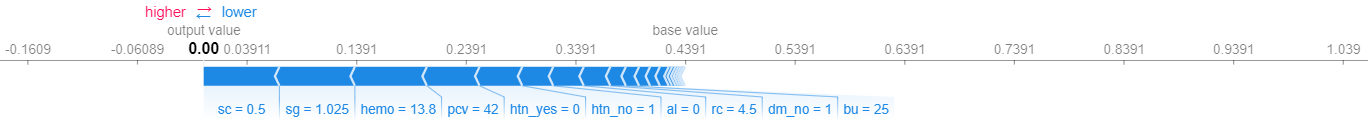

In [50]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values2[1], subject2)
Image("s2.PNG")

The second subject has a risk of kidney disease of 0. Serum Creatinine of 0.5, Specific Gravity of 1.025, and a high value of Hemoglobin lower the probability of disease.

In [36]:
print(clf.predict(X_test.loc[[25]]))
clf.predict_proba(X_test.loc[[25]])

[ True]


array([[0.04, 0.96]])

In [0]:
subject3 = X_test.loc[[25]]
shap_values3 = explainer.shap_values(subject3)

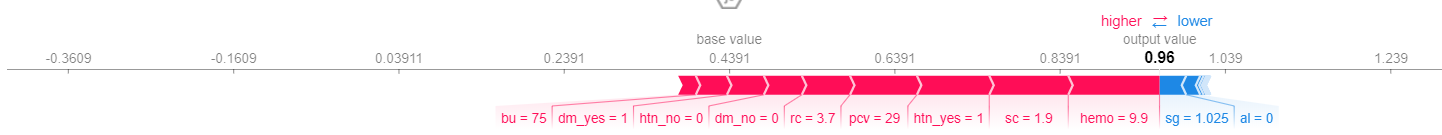

In [51]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values3[1], subject3)
Image("s3.PNG")

This subject has a high risk of kidney disese of 0.96, where a lower value of Hemoglobin of 9.9 and a Serum Creatinine of 1.9 highly increase the probability of disease.

In [39]:
print(clf.predict(X_test.loc[[15]]))
clf.predict_proba(X_test.loc[[15]])

[ True]


array([[0., 1.]])

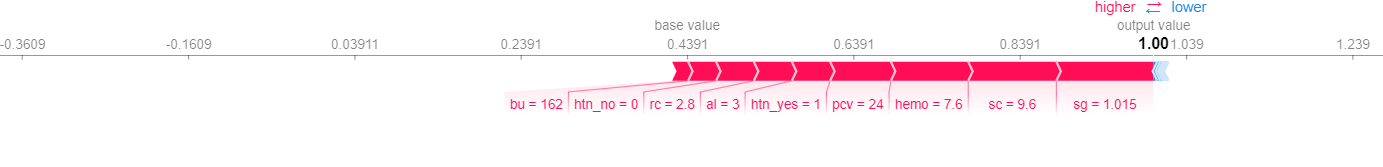

In [54]:
subject4 = X_test.loc[[15]]
shap.initjs()
shap_values4 = explainer.shap_values(subject4)
shap.force_plot(explainer.expected_value[1], shap_values4[1], subject4)
Image("S4.PNG")

For this subject, the probability of kidney disease of 1 is mostly increased by a low Hemoglobin of 7.6, a high Serum Creatinine of 9.6 and Specific Gravity of 1.015.

## SHAP Dependence Plots

A dependence plot represents the effect that a specific feature has on the predictions of the model.

### Dependence Plot for Hemoglobin

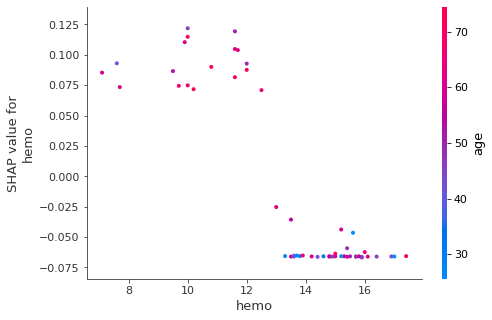

In [42]:
shap_values = explainer.shap_values(X_test)
shp_plt = shap.dependence_plot("hemo", shap_values[1], X_test)

The above plot shows that for higher values of Hemoglobin ( > 13 ), the risk of kidney disease is constantly lower, whereas for values under 13 the probability of disease is much higher. It also shows that Hemoglobin interacts with Age frequently. 

### Dependence Plot for Age


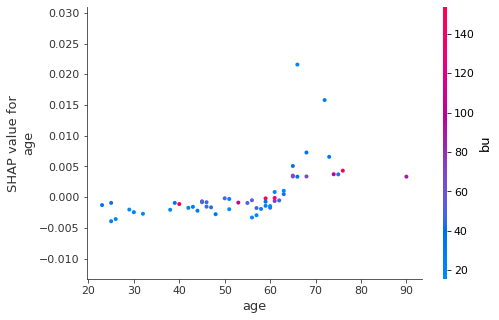

In [43]:
shp_plt = shap.dependence_plot("age", shap_values[1], X_test)

This plot shows that Age is not relevant for the target variable until it reaches values higher than 60, where it increases the probability of disease. Also it can be noted that Age interacts with Blood Urea("bu") frequently.

### Feature Importances Plot

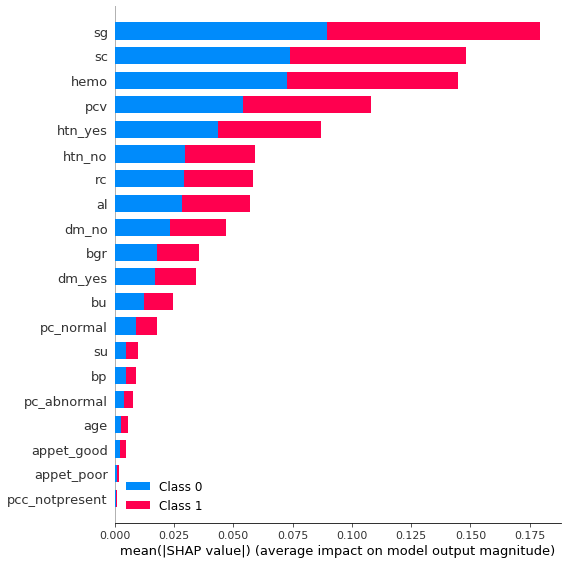

In [44]:
shap.summary_plot(shap_values, X_test)